In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cupy
def get_cupy():
    return cupy

In [ ]:
!pip install POT
import ot
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import time
from scipy.stats import ortho_group 
import collections
import matplotlib.pyplot as plt

In [ ]:
srcfile = open('/content/drive/My Drive/MAP512WordEmbedding/en.emb.txt', encoding='utf-8', errors='surrogateescape')
trgfile = open('/content/drive/My Drive/MAP512WordEmbedding/it.emb.txt', encoding='utf-8', errors='surrogateescape')
def read(file, dtype='float'):
    header = file.readline().split(' ')
    count = int(header[0]) 
    dim = int(header[1])
    words = []
    matrix = np.empty((count, dim), dtype=dtype) 
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        words.append(word)
        matrix[i] = np.fromstring(vec, sep=' ', dtype=dtype)
    return (words,matrix)
src_words, x = read(srcfile)
trg_words, z = read(trgfile)

In [ ]:
src_word2ind = {word: i for i, word in enumerate(src_words)}
trg_word2ind = {word: i for i, word in enumerate(trg_words)}

In [ ]:
src_indices = []
trg_indices = []
src2trg = collections.defaultdict(set)
oov = set()
vocab = set()
f = open('/content/drive/My Drive/MAP512WordEmbedding/en-it.train.txt', encoding='utf-8', errors='surrogateescape')
for line in f:
    src, trg = line.split()
    try:
        src_ind = src_word2ind[src]
        trg_ind = trg_word2ind[trg]
        src_indices.append(src_ind)
        trg_indices.append(trg_ind)
        src2trg[src_ind].add(trg_ind)
        vocab.add(src)
    except KeyError:
        print('WARNING: OOV dictionary entry ({0} - {1})'.format(src, trg), file=sys.stderr)
        oov.add(src)
src = list(src2trg.keys())
oov -= vocab

In [ ]:
S = x[src_indices]
T = z[trg_indices]

In [ ]:
xp = get_cupy()
S = xp.asarray(S)
T = xp.asarray(T)

In [ ]:

eps = 1e-8
S = S/(xp.linalg.norm(S,axis=1)[:, np.newaxis] + eps)
T = T/(xp.linalg.norm(T,axis=1)[:, np.newaxis] + eps)

In [ ]:
S.shape

(5000, 300)

In [ ]:
def cost(s,t):
    C = xp.zeros((5000,5000))
    for i in range(5000):
        C[i] = xp.linalg.norm(t[i] - s,axis=1)**2
    return C

In [ ]:
def get_accuracy(G0):
  xw = xp.asarray(x)@G0
  BATCH_SIZE = 500
  translation = collections.defaultdict(int)
    # Standard nearest neighbor
  for i in range(0, len(src), BATCH_SIZE):
      j = min(i + BATCH_SIZE, len(src))
      similarities = xw[src[i:j]].dot(T.T)
      nn = similarities.argmax(axis=1).tolist()
      for k in range(j-i):
          translation[src[i+k]] = trg_indices[nn[k]]
  accuracy = np.mean([1 if translation[i] in src2trg[i] else 0 for i in src])
  print(' Accuracy:{1:7.2%}'.format(1, accuracy))


In [ ]:
f = np.ones(5000)/5000
def train(r = 1000,lambd = 2e-2):
    G0 = xp.identity(300)#xp.asarray(ortho_group.rvs(dim=300))
    W0 = xp.zeros((5000,5000))
    W0[:r,:r] = xp.identity(r)
    #W0[r:,r:] = xp.asarray(np.random.random(size=(5000-r,5000-r))/10)#xp.asarray(ortho_group.rvs(dim=5000 - r))
    dlta = 1
    was_dist = 2
    wass_d_i = []
    dif_i = []
    
    fig, axs = plt.subplots(6, 2,figsize=(10,35))
    for k in range(10):
        usv = S.T @ W0 @ T

        u,s,vh = xp.linalg.svd(usv)
      
        nG = u @ vh
        step = xp.linalg.norm(nG - G0)
        dif_i.append(step)
        G0 = nG
        C = cost(S@G0,T) 
        
        n_was = xp.multiply(W0,C).sum()
        dlta = abs(was_dist - n_was)
        was_dist = n_was

        wass_d_i.append(was_dist)

        
        
       
        axs[k//2,k - 2*(k//2)].imshow(xp.asnumpy(W0)**.02,aspect='auto',cmap='Greys')
        print('delta wass dist = ', dlta,'  |Gn+1 - Gn| = ',step,'  was_dist = ',was_dist)
        
        W0 = xp.asarray(ot.sinkhorn(f,f,xp.asnumpy(C),lambd))

    axs[5,0].imshow(xp.asnumpy(W0)**.02,aspect='auto',cmap='Greys')
    axs[5,1].plot(range(len(wass_d_i)),wass_d_i)
    plt.show()
    return G0,wass_d_i,W0

In [ ]:
start_time = time.time()
G0,wass_01,W0 = train(50,0.1)
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(range(len(wass_01)-1),wass_01[1:])
plt.show()
get_accuracy(G0)

In [ ]:
start_time = time.time()
G0,wass_50,W0 = train(50,0.05)
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(range(len(wass_50)-1),wass_50[1:])
plt.show()
get_accuracy(G0)

In [ ]:
start_time = time.time()
G0,wass_03,W0_03 = train(50,0.03)
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(len(wass_03)-1),wass_03[1:])
plt.show()
get_accuracy(G0)

In [ ]:
start_time = time.time()
G0,wass_02,W0_2 = train(50,0.2)
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(len(wass_02)-1),wass_02[1:])
plt.show()
get_accuracy(G0)

In [ ]:
start_time = time.time()
G0,wass_05,W0_5 = train(50,0.5)
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(len(wass_05)-1),wass_05[1:])
plt.show()
get_accuracy(G0)

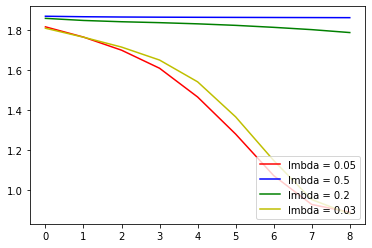

In [ ]:
n=len(wass_50)-1
w_05, = plt.plot(range(n),wass_50[1:],color="r")
w_5, = plt.plot(range(n),wass_05[1:],color="b")
w_02, = plt.plot(range(n),wass_02[1:],color="g")
w_03, = plt.plot(range(n),wass_03[1:],color="y")
#w_30, = plt.plot(range(n),wass_30[1:],color="k")
#w_20, = plt.plot(range(n),wass_20[1:],color="m")
#w_10, = plt.plot(range(n),wass_10[1:],color="c")

plt.legend([w_05,w_5,w_02,w_03],['lmbda = 0.05','lmbda = 0.5','lmbda = 0.2','lmbda = 0.03'],loc='lower right')

Accuracy: 86.20% for W = Id

Accuracy: 86.17% 3000

Accuracy:  0.06% no info

Accuracy: 85.74% 1000

Accuracy: 85.74% 600

Accuracy: 85.85%  300

Accuracy: 85.85% 100



In [ ]:
G0,wass_600,W0 = train(600)
plt.plot(range(len(wass_600)-1),wass_600[1:])
plt.show()
get_accuracy(G0)

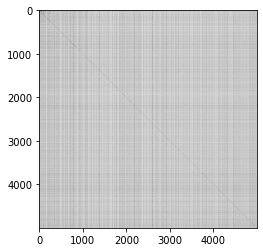

In [ ]:
W0 = xp.asnumpy(W0)
plt.imshow(W0**.02,cmap="Greys")

In [ ]:
G0,wass_300 = train(300)
#plt.plot(range(len(wass_300)-1),wass_300[1:])
#plt.show()
get_accuracy(G0)

In [ ]:
G0,wass_100 = train(100)
plt.plot(range(len(wass_100)-1),wass_100[1:])
plt.show()
get_accuracy(G0)

delta wass dist =  17.700415064652113   |Gn+1 - Gn| =  24.494792735778738   was_dist =  19.700415064652113
delta wass dist =  17.894515611022626   |Gn+1 - Gn| =  23.91488753127418   was_dist =  1.805899453629486
delta wass dist =  0.05450305952021495   |Gn+1 - Gn| =  23.58803464389056   was_dist =  1.751396394109271
delta wass dist =  0.05869600720492252   |Gn+1 - Gn| =  22.944386282050097   was_dist =  1.6927003869043484
delta wass dist =  0.08126115191468775   |Gn+1 - Gn| =  22.198640247216062   was_dist =  1.6114392349896607
delta wass dist =  0.13847347987433523   |Gn+1 - Gn| =  20.86215517425964   was_dist =  1.4729657551153255
delta wass dist =  0.2315011597042771   |Gn+1 - Gn| =  18.35058226965705   was_dist =  1.2414645954110484
delta wass dist =  0.254631110155899   |Gn+1 - Gn| =  13.775664747109671   was_dist =  0.9868334852551494
delta wass dist =  0.07873316541978626   |Gn+1 - Gn| =  8.34729873344358   was_dist =  0.9081003198353631
delta wass dist =  0.03203105103908288   

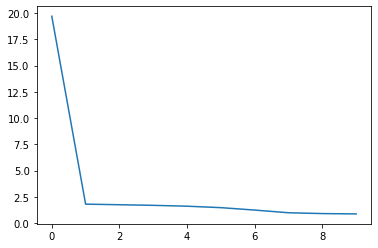

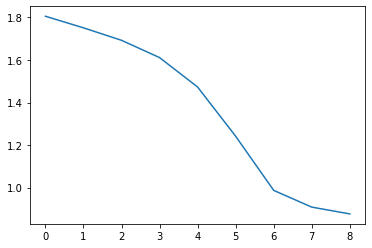

 Accuracy: 85.01%


In [ ]:
G0,wass_50 = train(50)
plt.plot(range(len(wass_50)-1),wass_50[1:])
plt.show()
get_accuracy(G0)

In [ ]:
G0,wass_10 = train(10)
plt.plot(range(len(wass_10)-1),wass_10[1:])
plt.show()
get_accuracy(G0)

In [ ]:
G0,wass_20 = train(20)
plt.plot(range(len(wass_20)-1),wass_20[1:])
plt.show()
get_accuracy(G0)

In [ ]:
G0,wass_30 = train(30)
plt.plot(range(len(wass_30)-1),wass_30[1:])
plt.show()
get_accuracy(G0)

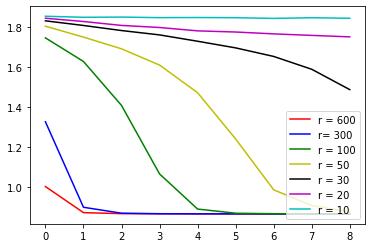

In [ ]:
n=len(wass_600)-1
w_600, = plt.plot(range(n),wass_600[1:],color="r")
w_300, = plt.plot(range(n),wass_300[1:],color="b")
w_100, = plt.plot(range(n),wass_100[1:],color="g")
w_50, = plt.plot(range(n),wass_50[1:],color="y")
w_30, = plt.plot(range(n),wass_30[1:],color="k")
w_20, = plt.plot(range(n),wass_20[1:],color="m")
w_10, = plt.plot(range(n),wass_10[1:],color="c")

plt.legend([w_600,w_300,w_100,w_50,w_30,w_20,w_10],['r = 600','r= 300','r = 100','r = 50','r = 30','r = 20','r = 10'],loc='lower right')

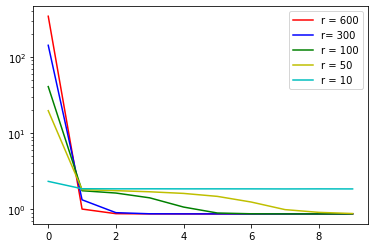

In [ ]:
n=len(wass_600)
plt.yscale('log')
w_600, = plt.plot(range(n),wass_600,color="r")
w_300, = plt.plot(range(n),wass_300,color="b")
w_100, = plt.plot(range(n),wass_100,color="g")
w_50, = plt.plot(range(n),wass_50,color="y")
w_10, = plt.plot(range(n),wass_10,color="c")
plt.legend([w_600,w_300,w_100,w_50,w_10],['r = 600','r= 300','r = 100','r = 50','r = 10'])